In [1]:
import requests

#common functions

#function to fetch data from given url
def FetchEPLDataFromUrl(urlPath, header):
    try:
        #add content header as text/csv for incoming data
        file = requests.get(urlPath, headers = header)
        return file.text
    except Exception as ex:
        print('Error fetching data from -', urlPath, 'Exception message -', ex)
        return False

#function to save downloaded data in given format
def SaveAsFile(content, fileName):
    try:
        file = open(fileName, 'w')
        file.write(content)
        file.close()
    except Exception as ex:
        print('Error saving file -', fileName, ' content - ', content, 'Exception message -', ex)

In [2]:
#season ranging from 2015-2024
seasons = list(range(15,26))
baseUrl = 'https://www.football-data.co.uk/mmz4281/'

for i, val in enumerate(seasons):
    if (i + 1) < len(seasons):
        #fetch per season data from specified url
        urlPath = baseUrl + str(val) + str(seasons[i + 1]) + '/E0.csv'
        dataContent = FetchEPLDataFromUrl(urlPath, {'content-type' : 'text/csv'})

        #save data per season as csv file only if valid
        if dataContent != False:
            fileName = 'season_' + str(val) + '-' + str(seasons[i + 1])  + '.csv'
            SaveAsFile(dataContent, fileName)

In [3]:
#imported glob package to fetch list of all .csv files in current working directory
import glob

files = glob.glob('*.csv')
print('List of csv files in current working directory -')
files

List of csv files in current working directory -


['season_24-25.csv',
 'season_23-24.csv',
 'season_16-17.csv',
 'season_21-22.csv',
 'season_15-16.csv',
 'season_22-23.csv',
 'season_17-18.csv',
 'season_20-21.csv',
 'season_18-19.csv',
 'season_19-20.csv']

In [4]:
#using pandas package to read csv data files
import pandas as pd

#temporarly limiting number of rows to display to 5, due to large amount of data
pd.options.display.max_rows = 5

originalData = []

#filtering columns
filteredColumns = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR']
matchesPerMonth = dict()

for file in files:
    #replacing null values & filtering file content in DataFrame format with only specific columns
    fileContent = pd.read_csv(file, usecols=filteredColumns, na_values=['NULL'])
    fileContent.name = file.split('.')[0]
    originalData.append(fileContent)
    fileContent['Season'] = fileContent.name.split('_')[1]



#creating a copy of original data to avoid any data loss
filteredData = originalData.copy()
# Concatenate the list of DataFrames
seasons = pd.concat(originalData)
seasons=seasons.sort_values(by='Date')

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


class MatchHistory:
    def __init__(self, t1, t2):
        # Query for matches between the two teams
        self.q1 = seasons.query(f'HomeTeam == "{t1}" and AwayTeam == "{t2}"')
        self.q2 = seasons.query(f'HomeTeam == "{t2}" and AwayTeam == "{t1}"')
        self.matchhis = pd.concat([self.q1, self.q2], ignore_index=True)
        # Store t1 and t2 as instance variables using self
        self.t1 = t1
        self.t2 = t2

    def get_match_count(self):
        # Count results for each match query
        counts1 = self.q1['FTR'].value_counts()
        counts2 = self.q2['FTR'].value_counts()

        # Create dataframes for each team's home matches
        # Access t1 and t2 using self
        df1 = pd.DataFrame({'Result count': counts1.values,
                            'Result': counts1.index,
                            'Home team': self.t1})
        df2 = pd.DataFrame({'Result count': counts2.values,
                            'Result': counts2.index,
                            'Home team': self.t2})
        matchcount = pd.concat([df1, df2], ignore_index=True)

        # Replace shorthand result codes with descriptive labels
        matchcount['Result'] = matchcount['Result'].replace({
            'A': 'Home team loses',
            'D': 'Draw',
            'H': 'Home team wins'
        })

        self.matchcount = matchcount
        return self.matchcount

    def view_matches(self):
        # Display the match history DataFrame
        return self.matchhis
    def plot(self):
      # Plot the value counts using Seaborn
      sns.set_context("notebook", font_scale=1.5)
      sns.dark_palette("#79C")
      sns.set_theme()
      sns.catplot(
          data=self.matchcount, x="Home team", y="Result count", hue="Result",
            kind="bar")
      # Access t1 and t2 using self for the plot title
      plt.title(f'2015 - 2024 {self.t1} vs {self.t2} match history')

      plt.ylabel('Count', size=16, family='monospace')
      plt.show()



Match History:
          Date    HomeTeam    AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR Season
0   10/04/2016   Tottenham  Man United     3     0   H     0     0   D  15-16
1   11/04/2021   Tottenham  Man United     1     3   A     1     0   H  20-21
..         ...         ...         ...   ...   ...  ..   ...   ...  ..    ...
17  28/10/2017  Man United   Tottenham     1     0   H     0     0   D  17-18
18  29/09/2024  Man United   Tottenham     0     3   A     0     1   A  24-25

[19 rows x 10 columns]

Match Counts:
    Result count           Result   Home team
0              4   Home team wins   Tottenham
1              3  Home team loses   Tottenham
..           ...              ...         ...
4              3  Home team loses  Man United
5              1             Draw  Man United

[6 rows x 3 columns]


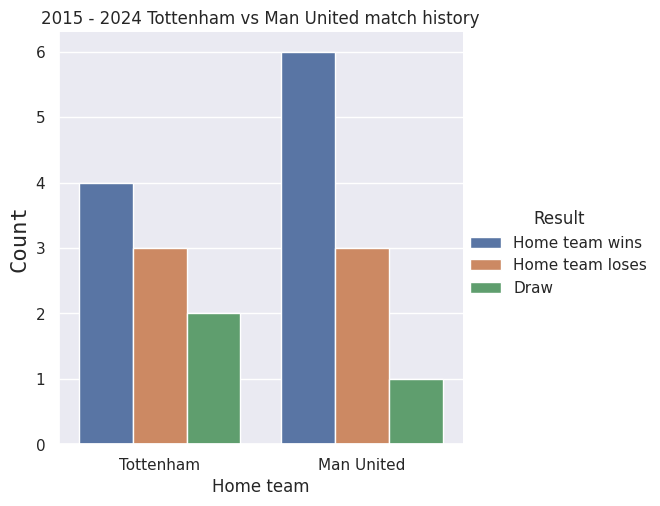

In [7]:
# Instantiate the class and call methods
his = MatchHistory("Tottenham", "Man United")

# View the match history
match_history_df = his.view_matches()
print("Match History:")
print(match_history_df)

# View the match counts
match_counts_df = his.get_match_count()
print("\nMatch Counts:")
print(match_counts_df)

his.plot()